<a href="https://colab.research.google.com/github/drAshcroft/MAT422/blob/main/HW_33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
!pip install lmfit
from lmfit import create_params, minimize

We create a dataset from a function that describes the tunneling of electrons through a simple barrier.  The function is complicate and cannot be easily linearized.  In order to curve fit this data, we will need to minimize a residual system

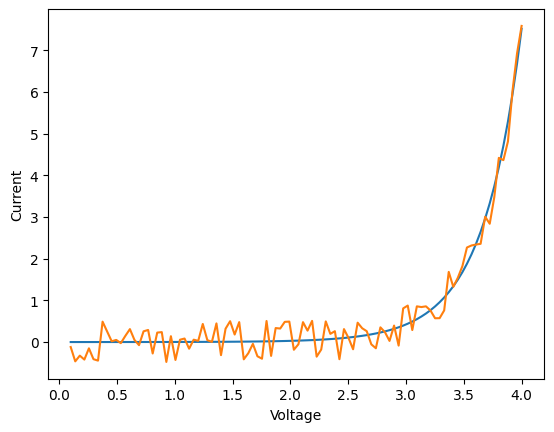

In [15]:
#Model of electron tunneling through a metal insulator metal interface
def I(v,S,phi0,K): #returns amps/m^2
    s1=6/K/phi0

    s2=np.where(v<phi0,S*(1-46/(3*phi0*K*S+20-2*v*K*S))+s1 ,(phi0*K*S-28)/K/v )
    ds=s2-s1
    phi=phi0-(v/2/S)*(s1+s2)-(5.75/K/(s2-s1))*np.log(s2/s1*(S-s1)/(S-s2))

    return 1e6* (6.2e10/ds/ds)*(  phi*np.exp(-1.025*ds*phi**.5)-(phi+v)*np.exp(-1.025*ds*(phi+v)**.5) )


#starting parameters that we wish to recover
S0 = 20
phi00= 5
K0=6

#convert the function to a real dataset with guassian noise added in
x=np.linspace(0.1,4,100)
plt.plot(x,I(x,S0,phi00,K0))
Y=I(x,S0,phi00,K0)+ 1*(.5-np.random.ranf(len(x)))

#show the data
plt.plot(x,Y)
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.show()

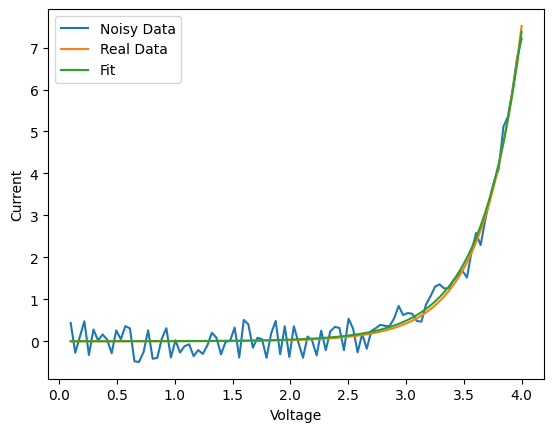

Parameter, Real value,Fitted Value,Error
S,      20.00,    19.13,    0.87
phi,     5.00,     4.69,    0.31
k,       6.00,    80.00,  -74.00


In [13]:
#we define the residual of the data to the calculated model.  This is done by creating a
#new noiseless funtion for each datapoint and then subtracting.  'minimize' uses a variety
#of methods to minimize the MSE defined by the residual function
def residual(pars, x, data=None):
    model =I(x,pars['S'] ,pars['phi0'] ,pars['K'])
    model[(np.isnan(model))]=0
    if data is None:
        return model
    return model - data

#we provide the minimize function inital guesses for the parameters and acceptable bounds for the parameters
fit_params = create_params(S=dict(value=30, max=100, min=5),
                          phi0=dict(value=5, max=6, min=1),
                          K=dict(value=2, max=80, min=.1),
                          )


#minimize the function using the fitting parameters
out = minimize(residual, fit_params, args=(x,), kws={'data':  Y  })

#chart the output
plt.plot(x,Y, label='Noisy Data')
plt.plot(x,I(x,S0,phi00,K0),label='Real Data')
plt.plot(x,I(x,out.params['S'],out.params['phi0'], out.params['K']),label='Fit')
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.legend()
plt.show()

print( "Parameter, Real value,Fitted Value,Error")
print(f"S,      {S0:.2f},    {out.params['S'].value:.2f},    {(S0-out.params['S'].value):.2f}")
print(f"phi,     {phi00:.2f},     {out.params['phi0'].value:.2f},    {phi00-out.params['phi0'].value:.2f}")
print(f"k,       {K0:.2f},    {out.params['K'].value:.2f},  {K0-out.params['K'].value:.2f}")


As can be seen from the fitting table. A common problem that occurs with non linear fitting is that the initial conditions can be problematic and result in incorrect local solutions.  The relationship between phi and k is very complicated and it is easy for the fitting routine to get lost.

In [14]:
out

The correlation function shows how difficult this function is to fit, meaning a lot of care must be taken to handle this data.  Some level of math legerdomain may make the fitting more stable.